# Investigating COVID-19 Transmission in Supermarkets
By: Rebecca Flach and Daniel Quinteros

The following code extends the research conducted in [**Modeling COVID-19 transmission in supermarkets using an agent-based model**](https://www.semanticscholar.org/reader/17a2627fca7585df99f9d214831992a3756ed772) by Fabian Ying, Neave O’Clery. We adapt the model to simulate the same experiments within the dining hall of Olin College of Engineering.

In [47]:
!pip install covid19-supermarket-abm

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from covid19_supermarket_abm.utils.load_example_data import load_example_store_graph
from covid19_supermarket_abm.utils.create_synthetic_baskets import get_all_shortest_path_dicts
from covid19_supermarket_abm.path_generators import get_path_generator
from covid19_supermarket_abm.simulator import simulate_several_days
from covid19_supermarket_abm.utils.create_store_network import create_store_network

### Default Dining Hall Simulations

Create and visualize the dining hall network where the simulations will occur

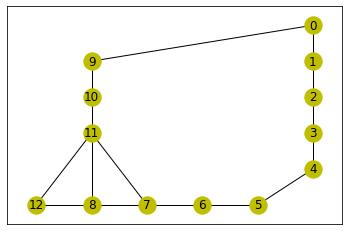

In [89]:
pos = {0: (5,5), 1: (5,4), 2: (5,3), 3: (5,2), 4:(5,1), 5:(4, 0), 6:(3, 0), 7:(2,0), 8:(1,0), 9:(1, 4), 10:(1, 3), 11:(1, 2), 12:(0,0)}
edges = [(0,1), (0,9), (1,2), (2,3), (3, 4), (4,5), (5,6), (6,7), (7,8), (7,11), (8,11), (8,12), (9,10), (10, 11), (11,12)]
dh_graph = create_store_network(pos=pos, edges=edges)

# 0: Swipe In
# 1 - 7: Entrees
# 8: Soda Machine
# 9 - 10: Chef's Table? I don't know what it's called
# 11: Silverware
# 12: Exit
 
nx.draw_networkx(dh_graph, pos=pos, node_color="y")

Create a path generator which feeds our model with student paths

In [90]:
entrance_nodes = [0]  # Swipe In
till_nodes = [8, 11]  # Soda Machine, Silverware
exit_nodes = [12]  # Exit
item_nodes = [1, 2, 3, 4, 5, 6, 7, 9, 10] # Food
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(dh_graph)
synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

Simulate the dining hall operations under the default configuration parameters

In [51]:
config = {'arrival_rate': 2.55,  # Poisson rate at which students arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # dining hall opening hours
           'infection_proportion': 0.0011,  # proportion of students that are infectious
         }

# Simulate several days and store results in default_sim_results
num_days = 1000
default_sim_results = simulate_several_days(config, dh_graph, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


Calculate the average number of daily infections based on the mean total exposure time

In [52]:
transmission_rate = 1.41 * pow(10, -9)
default_infections = (default_sim_results[0]['total_exposure_time'].mean()) * transmission_rate

print("Mean Total Exposure Time: ", default_sim_results[0]['total_exposure_time'].mean(), "minutes"
      "\nAverage # of Daily Infections: ", default_infections)

Mean Total Exposure Time:  2.97401576468685 
Average # of Daily Infections:  4.193362228208459e-09


### Dining Hall Network Heatmap Visualization

Based on mean exposure time in each zone. The color ranges from black to bright red. The brighter the red, the higher the average exposure time is in that zone.

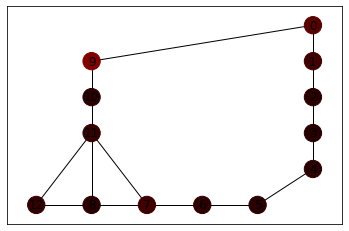

In [53]:
exposures = default_sim_results[2].mean(0)
nx.draw_networkx(dh_graph, pos=pos, node_color=[(exposure, 0, 0) for exposure in exposures])

## Covid Exposure Interventions

### Restricting Maximum Number of Students in Dining Hall

Perform a parameter sweep, varying the maximum dining hall capacity from 1 to 30 students.

In [55]:
max_capacity_infections = []

config = {'arrival_rate': 2.55,  # Poisson rate at which students arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # dining hall opening hours
           'infection_proportion': 0.0011,  # proportion of students that are infectious
           'max_customers_in_store_per_sqm': 0,  # Maximum number of students per sqm (per zone) 
           'floorarea': 100  # Floor area (1 sqm per zone)
          #  'max_customers_in_store' = max_customers_in_store_per_sqm * floorarea
         }


transmission_rate = 1.41 * pow(10, -9)
max_capacities = np.linspace(0.01, 0.3, 30)
for store_limit in max_capacities:
    config['max_customers_in_store_per_sqm'] = store_limit
    max_capacity_sim_results = simulate_several_days(config, dh_graph, path_generator_function, path_generator_args, num_iterations=1000,
                                    use_parallel=False)
    max_capacity_infections.append((max_capacity_sim_results[0]['total_exposure_time'].mean()) * transmission_rate)

100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


Text(0.5, 1.0, 'Infections v. Max. Capacity')

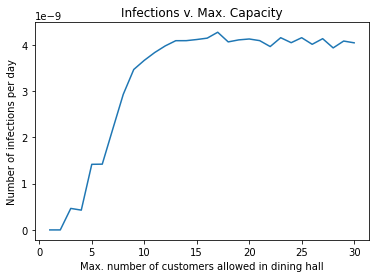

In [56]:
plt.plot(max_capacities * config['floorarea'], max_capacity_infections)
plt.xlabel('Max. number of customers allowed in dining hall')
plt.ylabel('Number of infections per day')
plt.title('Infections v. Max. Capacity')

### Varying Student Arrival Rate

Perform a parameter sweep, varying the rate at which students enter the dining hall from 0 to 6 students/min.

In [57]:
arrival_rate_infections = []

config = {'arrival_rate': 0,  # Poisson rate at which students arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # dining hall opening hours
           'infection_proportion': 0.0011,  # proportion of students that are infectious
         }

transmission_rate = 1.41 * pow(10, -9)
arrival_rates = np.linspace(0, 6, 25)
for rate in arrival_rates:
    config['arrival_rate'] = rate
    arrival_rate_sim_results = simulate_several_days(config, dh_graph, path_generator_function, path_generator_args, num_iterations=1000,
                                    use_parallel=False)
    arrival_rate_infections.append((arrival_rate_sim_results[0]['total_exposure_time'].mean()) * transmission_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/daniel_quinteros/anaconda3/lib/python3.9/random.py:619: RuntimeWarning: divide by zero encountered in double_scalars
  return -_log(1.0 - self.random()) / lambd
/home/daniel_quinteros/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel_quinteros/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s]


Text(0.5, 1.0, 'Infections v. Student Arrival Rate')

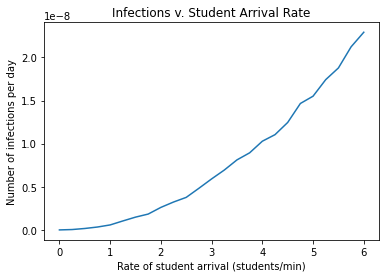

In [58]:
plt.plot(arrival_rates, arrival_rate_infections)
plt.xlabel('Rate of student arrival (students/min)')
plt.ylabel('Number of infections per day')
plt.title('Infections v. Student Arrival Rate')

### Face Masks

Implementation of a fask mask policy via a reduction in the transmission rate.

In [59]:
# Set parameters
rrr = 0.17  # Relative transmission risk reduction

config = {'arrival_rate': 2.55 * rrr,  # Poisson rate at which students arrive * rrr
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # dining hall opening hours
           'infection_proportion': 0.0011,  # proportion of students that are infectious
         }

# Simulate several days and store results in face_mask_sim_results
num_days = 1000
face_mask_sim_results = simulate_several_days(config, dh_graph, path_generator_function, path_generator_args, num_iterations=num_days,
                                use_parallel=False)

100%|██████████| 1000/1000 [00:36<00:00, 27.17it/s]


Calculate the average number of daily infections based on the mean total exposure time

In [60]:
transmission_rate = 1.41 * pow(10, -9)
face_mask_infections = (face_mask_sim_results[0]['total_exposure_time'].mean()) * transmission_rate

print("Mean Total Exposure Time: ", face_mask_sim_results[0]['total_exposure_time'].mean(), 
      "\nAverage # of Daily Infections: ", face_mask_infections)

Mean Total Exposure Time:  0.09093280015157845 
Average # of Daily Infections:  1.2821524821372563e-10
